<a href="https://colab.research.google.com/github/clm7373/Methods-in-Quantitative-Biology-Fall-2021/blob/main/cm_Image_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Images in Python

In [3]:
%%capture
!pip3 install scikit-image==0.18.3

In [4]:
import skimage
print(skimage.__version__)

0.18.3


In [5]:
import numpy as np
from skimage import data, io, color, filters, morphology, util
from skimage import exposure, measure, feature, segmentation, restoration
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
import scipy.ndimage as ndi

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Cat picture
cat_image = data.chelsea()

'''Question: what is the image type of the cat image'''

# Cat image is loaded as a numpy array
cat_image

array([[[143, 120, 104],
        [143, 120, 104],
        [141, 118, 102],
        ...,
        [ 45,  27,  13],
        [ 45,  27,  13],
        [ 45,  27,  13]],

       [[146, 123, 107],
        [145, 122, 106],
        [143, 120, 104],
        ...,
        [ 46,  29,  13],
        [ 45,  29,  13],
        [ 47,  30,  14]],

       [[148, 126, 112],
        [147, 125, 111],
        [146, 122, 109],
        ...,
        [ 48,  28,  17],
        [ 49,  29,  18],
        [ 50,  30,  19]],

       ...,

       [[ 92,  58,  30],
        [105,  71,  43],
        [132,  98,  71],
        ...,
        [172, 145, 138],
        [172, 145, 138],
        [172, 145, 138]],

       [[128,  92,  60],
        [139, 103,  71],
        [134,  95,  64],
        ...,
        [166, 142, 132],
        [166, 142, 132],
        [167, 143, 133]],

       [[139, 103,  71],
        [127,  88,  57],
        [125,  86,  53],
        ...,
        [161, 137, 127],
        [161, 137, 127],
        [162, 138, 128]]

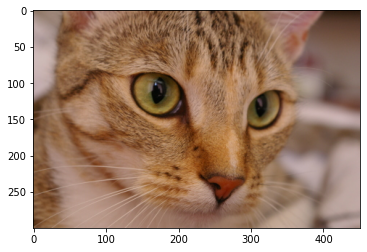

In [8]:
# Use imshow from matplotlib to display data as an image
plt.imshow(cat_image)

In [9]:
# Some basic information
print("image shape (height, width, colors):", cat_image.shape)
print("image type:", cat_image.dtype)
print("Min/max of image pixels:", cat_image.min(), cat_image.max())
print("RGB values for pixel in upper left corner:", cat_image[0][0])
print("Min/max of red channel pixels:", cat_image[:,:,0].min(), cat_image[:,:,0].max())

image shape (height, width, colors): (300, 451, 3)
image type: uint8
Min/max of image pixels: 0 231
RGB values for pixel in upper left corner: [143 120 104]
Min/max of red channel pixels: 2 215


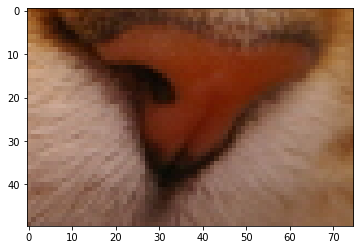

In [10]:
# Slice (crop) image (rows first, counting down from the top)
cat_nose=cat_image[225:275,225:300,:]
plt.imshow(cat_nose)

image shape: (height, width): (300, 451)
image type: float64


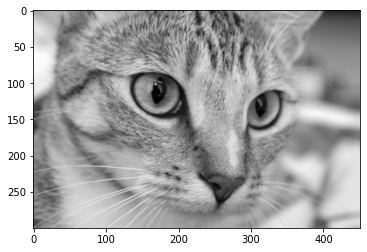

In [11]:
# Convert to greyscale
cat_image_gray=color.rgb2gray(cat_image)
plt.imshow(cat_image_gray, cmap="gray")
print("image shape: (height, width):", cat_image_gray.shape)
print("image type:", cat_image_gray.dtype)

# rgb to grey converts rgb values to luminance (~brightness) 
# Y = 0.2125 R + 0.7154 G + 0.0721 B (floating point 0-1)

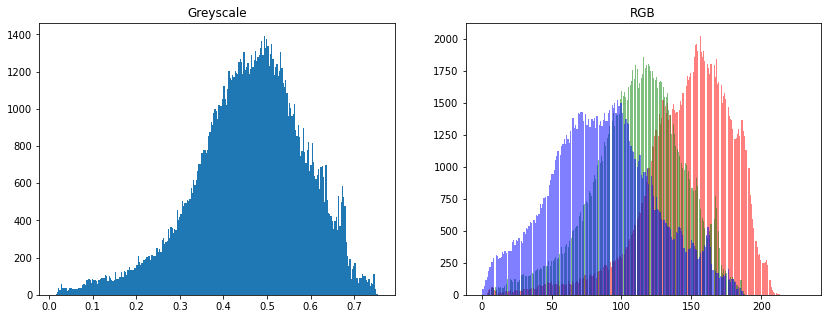

In [12]:
# Intensity Histograms
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Greyscale")
img_hist = plt.hist(cat_image_gray.ravel(), bins=256, )

plt.subplot(1,2,2)
plt.title("RGB")
img_hist=plt.hist(cat_image[:,:,0].ravel(), bins=256, color='red', alpha=0.5)
img_hist=plt.hist(cat_image[:,:,1].ravel(), bins=256, color='green', alpha=0.5)
img_hist=plt.hist(cat_image[:,:,2].ravel(), bins=256, color='blue', alpha=0.5)



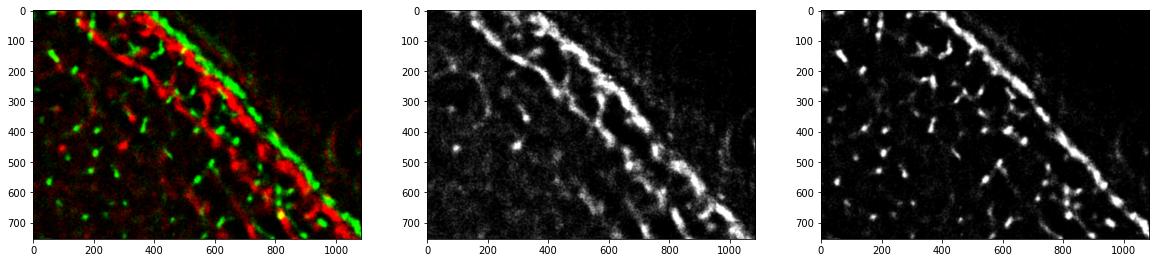

In [13]:
# extract data from color channels of a fluorescence microscopy image
# dSTORM Image / Marta Perez-Hernandez
# * use imread to read in images from files *
dStorm_img=io.imread("https://raw.githubusercontent.com/FenyoLab/ImageAnalysisClass/main/spool_12_Reconstruction_smoothed.tif")

plt.figure(figsize=(20,30))
plt.subplot(1,3,1)
plt.imshow(dStorm_img)

plt.subplot(1,3,2)
plt.imshow(dStorm_img[:,:,0], cmap="gray")

plt.subplot(1,3,3)
plt.imshow(dStorm_img[:,:,1], cmap="gray")


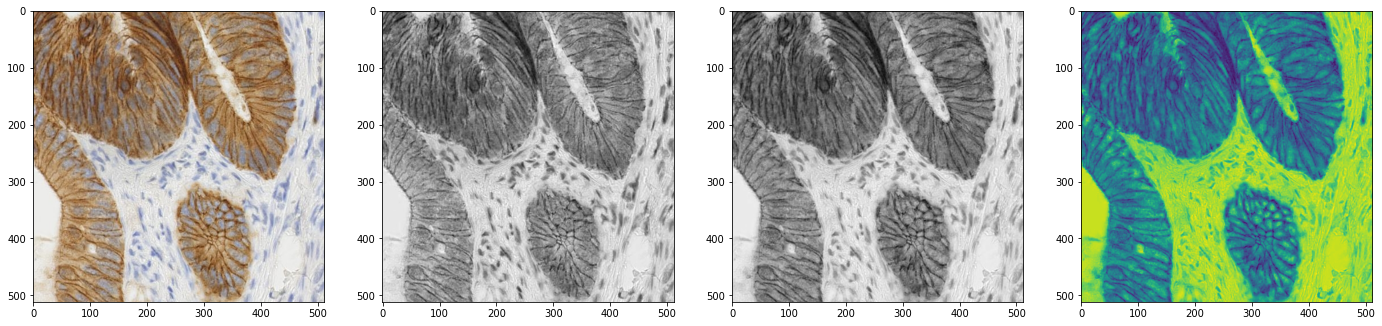

In [14]:
# Immunohistochemistry (Haematoxylin-Eosin-DAB (HED)) - separation of structures
# color information stored in RGB channels does not separate based on the staining

from skimage.color import rgb2hed, hed2rgb
ihc_rgb = data.immunohistochemistry()

plt.figure(figsize=(24,7))

plt.subplot(1,4,1)
plt.imshow(ihc_rgb)

# Hematoxylin (purple/blue)
plt.subplot(1,4,2)
plt.imshow(ihc_rgb[:,:,0], cmap="gray") 

# Eosin (pink)
plt.subplot(1,4,3)
plt.imshow(ihc_rgb[:,:,1], cmap="gray") 

# DAB (brown)
plt.subplot(1,4,4)
plt.imshow(ihc_rgb[:,:,2], ) 

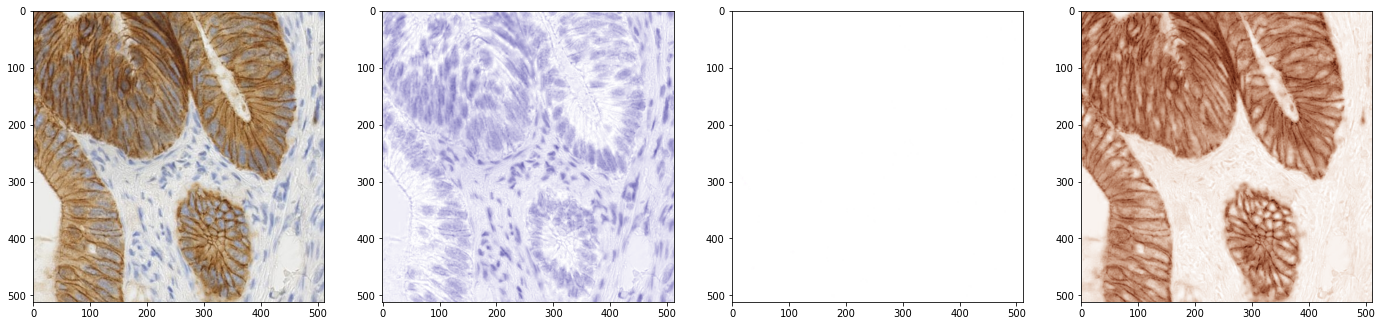

In [15]:
# use scikit-image package to apply color "deconvolution" operation 
# RGB to Haematoxylin-Eosin-DAB (HED) color space conversion:
# deconvolve the color information acquired with red-green-blue (RGB) cameras 
# to calculate the contribution of each of the stains based on stain-specific RGB absorption

ihc_hed = rgb2hed(ihc_rgb) # extract Hematoxylin, Eosin and DAB color contributions from the RGB channels

plt.figure(figsize=(24,7))

plt.subplot(1,4,1)
plt.imshow(ihc_rgb)

# Hematoxylin (purple/blue)
plt.subplot(1,4,2)
# make an array of all zeros that has same shape as a single channel of the orig image
blank_ch = np.zeros_like(ihc_hed[:, :, 0]) 
# np.stack will combine the channels into RGB format (axis=-1 means stack on the last dimension)
ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], blank_ch, blank_ch), axis=-1)) 
plt.imshow(ihc_h) 

# Eosin (pink)
plt.subplot(1,4,3)
ihc_e = hed2rgb(np.stack((blank_ch, ihc_hed[:, :, 1], blank_ch), axis=-1))
plt.imshow(ihc_e) 

# DAB (brown)
plt.subplot(1,4,4)
ihc_d = hed2rgb(np.stack((blank_ch, blank_ch, ihc_hed[:, :, 2]), axis=-1))
plt.imshow(ihc_d) 


In [16]:
#plt.imshow(ihc_hed[:, :, 0], cmap='gray') 
ihc_hed[:, :, 0]

array([[0.01315851, 0.01107797, 0.01307696, ..., 0.05664113, 0.04503623,
        0.03400574],
       [0.01935822, 0.01848498, 0.01921994, ..., 0.04924608, 0.04617668,
        0.04110789],
       [0.02827896, 0.02610673, 0.02343475, ..., 0.04425414, 0.04750952,
        0.04685105],
       ...,
       [0.01003739, 0.00813445, 0.005173  , ..., 0.01511437, 0.01381533,
        0.01261752],
       [0.01201298, 0.01006645, 0.00703912, ..., 0.01471686, 0.01502974,
        0.01318161],
       [0.01006645, 0.01006645, 0.00929977, ..., 0.01635741, 0.01519995,
        0.01318161]])

# Filters, Background subtraction, and Contrast Enhance

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


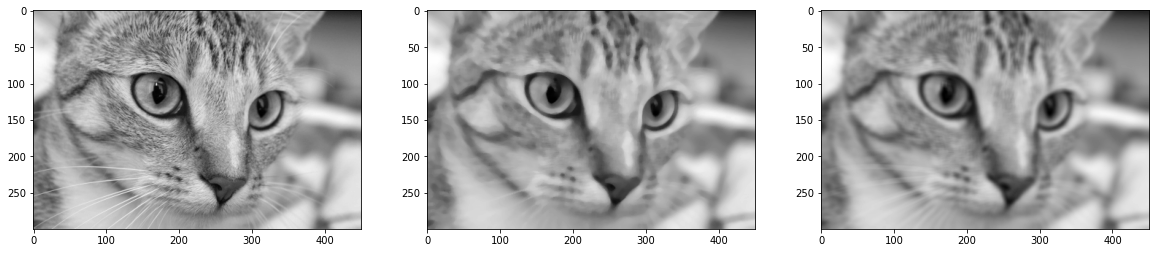

In [17]:
# Filters

#structuring element
size=7
el=morphology.square(size)
#el=morphology.disk(size)

plt.figure(figsize=(20,30))
plt.subplot(1,3,1)
plt.imshow(cat_image_gray, cmap='gray')

plt.subplot(1,3,2)
cat_filt_med=filters.rank.median(cat_image_gray, selem=el)
plt.imshow(cat_filt_med, cmap='gray')

plt.subplot(1,3,3)
cat_filt_mean=filters.rank.mean(cat_image_gray, selem=el)
plt.imshow(cat_filt_mean, cmap='gray')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  from ipykernel import kernelapp as app


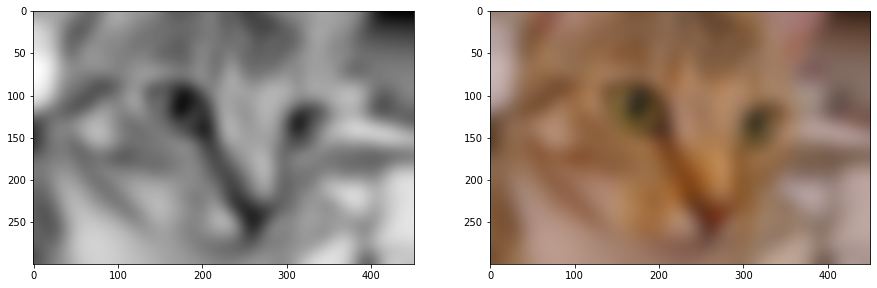

In [24]:
'''
Activity - Apply a gaussian filter to the cat image?
Try different values for sigma to see the results

What if you apply the gaussian filter to the color image: does this work too?
What is the difference between setting the "multichannel" parameter to True or False? 
'''

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
cat_filter_gauss=filters.gaussian(cat_image_gray, sigma=10) # fix
plt.imshow(cat_filter_gauss, cmap='gray')

plt.subplot(1,2,2)
cat_filter_gauss_rgb=filters.gaussian(cat_image, sigma=10, ) # fix, use cat_image 
plt.imshow(cat_filter_gauss_rgb)


when sigma is lower finer edges are detected, when higher , the main edges are shown the gaussian filter acts to reduce noise on color image as well. The multchannel setting affects wether each color channel is filtered seperately 

In [19]:
# Kernel: Sharpening 
def make_sharpen_kernel(amount=1):
  """Make 3x3 sharpening kernal"""
  source=np.zeros(shape=(3,3))
  source[1][1]=1
  edge_det=np.asarray([[0,-1,0],[-1,4,-1],[0,-1,0]])
  return source+(edge_det*amount)

In [20]:
print(make_sharpen_kernel())
print()
print(make_sharpen_kernel(2))

[[ 0. -1.  0.]
 [-1.  5. -1.]
 [ 0. -1.  0.]]

[[ 0. -2.  0.]
 [-2.  9. -2.]
 [ 0. -2.  0.]]


'Question: why are some pixels in the center of the eye white?'

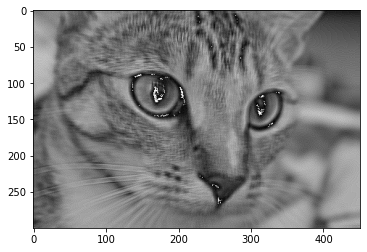

In [27]:
# Convolve the image
sharpen=ndi.convolve(cat_filt_mean, make_sharpen_kernel(5), )
plt.imshow(sharpen, cmap="gray")

'''Question: why are some pixels in the center of the eye white?'''


this is an artifact due to oversharpening - increases with increase kernal

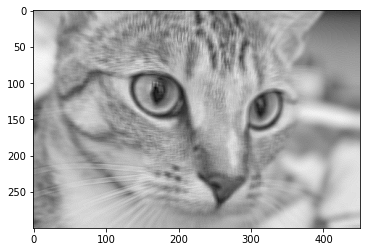

In [28]:
# Use "output" parameter with an array of type int16 to allow 
# values from -32768 to 32767
sharpen=np.zeros(cat_filt_mean.shape, dtype='int16')
ndi.convolve(cat_filt_mean, make_sharpen_kernel(3), output=sharpen)
plt.imshow(sharpen, cmap="gray")

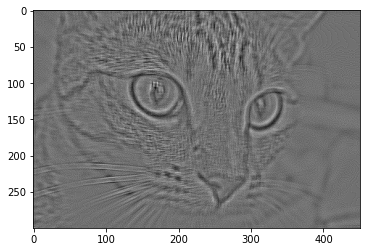

In [29]:
# Edge Detection
edge=np.zeros(cat_filt_mean.shape, dtype='int16')
ndi.convolve(cat_filt_mean, np.asarray([[0,-1,0],[-1,4,-1],[0,-1,0]]), output=edge)
plt.imshow(edge, cmap="gray")


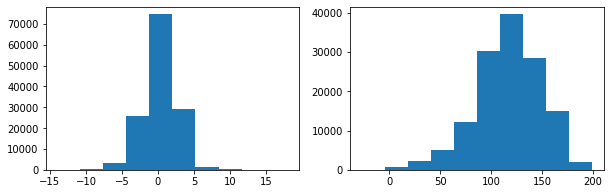

In [30]:

# Sharpen results in a wider range of values than Edge
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
ret=plt.hist(edge.ravel())

plt.subplot(1,2,2)
ret=plt.hist(sharpen.ravel())


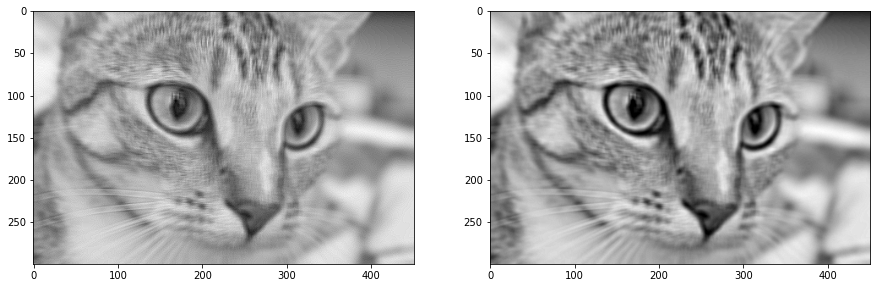

In [31]:
# Unsharp mask
unsharp_mask = filters.unsharp_mask(cat_filt_mean, radius=2, amount=3)
# radius for blurring, amount for sharpening

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(sharpen, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(unsharp_mask, cmap="gray")

In [ ]:
# Saving an image to a file - convert to a readable format
print(unsharp_mask.dtype)
io.imsave("/content/drive/My Drive/Colab Data/cat_unsharp.tif", unsharp_mask)

unsharp_mask_8bit=util.img_as_ubyte(unsharp_mask)  # do not use: unsharp_mask.astype('uint8')
io.imsave("/content/drive/My Drive/Colab Data/cat_unsharp_8_bit.tif", unsharp_mask_8bit)

In [ ]:
# Rolling ball background subtraction
# Read an image from a URL (or local file)
fl_img=io.imread("https://raw.githubusercontent.com/FenyoLab/ImageAnalysisClass/main/img13_cropped.gif")

'''Activity: can you try different values for the radius to see what works best'''

background = restoration.rolling_ball(fl_img, radius=150)
# > 300 might take a while to run

plt.figure(figsize=(20,30))
plt.subplot(1,3,1)
plt.imshow(fl_img, cmap='gray')

plt.subplot(1,3,2)
plt.imshow(background, cmap='gray')

plt.subplot(1,3,3)
plt.imshow(fl_img-background, cmap='gray')

(960, 1280) uint8


(-0.5, 1279.5, 959.5, -0.5)

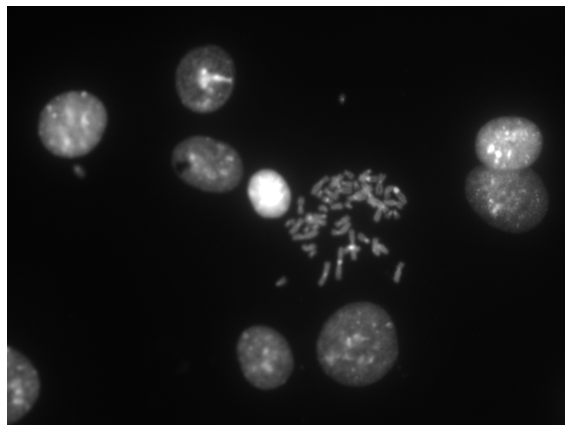

In [34]:
# Image courtesy Nazario Bosco
# Blue channel, DAPI (fluorescent DNA stain)
nuclei_image=io.imread("https://raw.githubusercontent.com/FenyoLab/ImageAnalysisClass/main/45_DAPI.tif")
print(nuclei_image.shape, nuclei_image.dtype)

plt.figure(figsize=(10,10))
plt.imshow(nuclei_image, cmap="gray")
plt.axis('off')

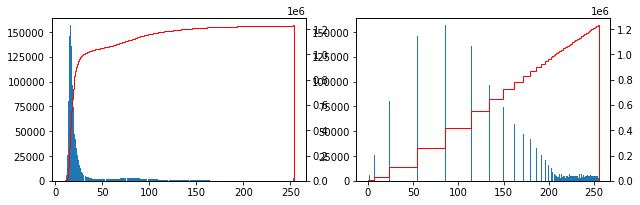

In [35]:
# Contrast enhance
# Histogram equalization
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
ret=plt.hist(nuclei_image.ravel(), bins=256)
ax = plt.gca().twinx()
ret=ax.hist(nuclei_image.ravel(), bins=256, cumulative=True, histtype='step', color='red')

img_eq = util.img_as_ubyte(exposure.equalize_hist(nuclei_image))
plt.subplot(1,2,2)
ret=plt.hist(img_eq.ravel(), bins=256)
ax = plt.gca().twinx()
ret=plt.hist(img_eq.ravel(), bins=256, cumulative=True, histtype='step', color='red')

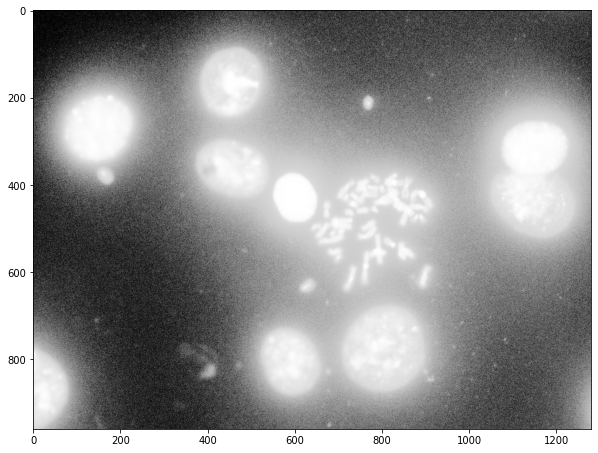

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(img_eq, cmap="gray")

'\nActivity: try different values for kernel_size and clip_limit \nWhat happens when each is changed?  Why?\n(Can you make the CLAHE image look like the image above?)\n'

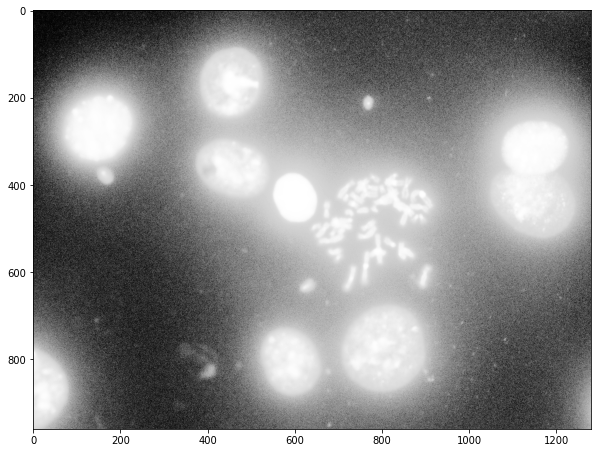

In [52]:
# CLAHE - contrast limited adaptive histogram equalization

img_eq_adapt = exposure.equalize_adapthist(nuclei_image, kernel_size=1000, clip_limit=1) #kernel_size=150, clip_limit=.01)
plt.figure(figsize=(10,10))
plt.imshow(img_eq_adapt, cmap="gray")

"""
Activity: try different values for kernel_size and clip_limit 
What happens when each is changed?  Why?
(Can you make the CLAHE image look like the image above?)
"""

Smaller kernal size leads to decreased contrast as this defines the shape of area algorithm is applied to, higher cliplimit values lead to more contrast

# Thresholding

Otsu threshold = 64


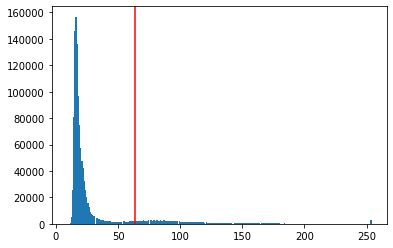

In [53]:
# Calculate threshold using Otsu algorithm
otsu_th = filters.threshold_otsu(nuclei_image)
print("Otsu threshold =", otsu_th)
ret=plt.hist(nuclei_image.ravel(), bins=256)
plt.axvline(otsu_th,color="red")

bool


(-0.5, 1279.5, 959.5, -0.5)

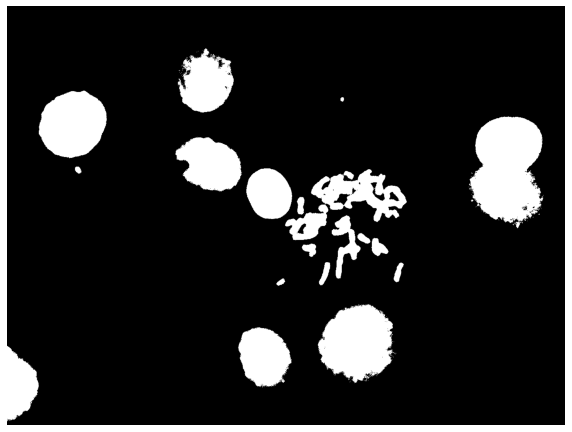

In [54]:
# Apply a threshold to an image to get a binary image
nuclei_mask = nuclei_image > otsu_th
print(nuclei_mask.dtype)

plt.figure(figsize=(10,10))
plt.imshow(nuclei_mask, cmap='gray')
plt.axis('off')

(960, 1280)


'\nActivity: \n\nTry different values for block_size and offset to try to get better results\n\nOffset is a constant subtracted from the local filter value\nWould making the value of the local filter higher or lower help?\n\n'

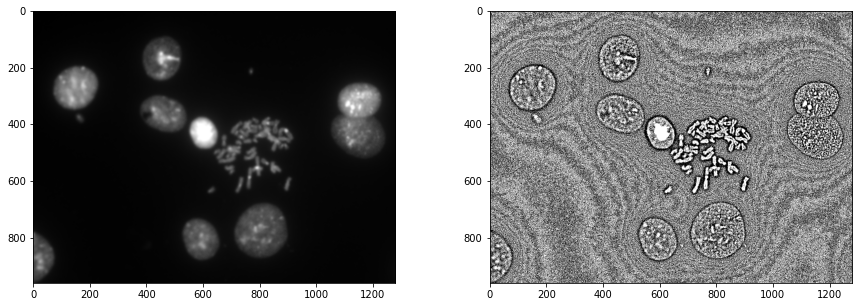

In [76]:
# local thresholding
block_size=7

img_th = filters.threshold_local(nuclei_image, block_size, method="mean", offset=.1)

#img_th is the same shape as the input image, since it produces a threshold value for each pixel
print(img_th.shape)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(img_th, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(nuclei_image>img_th, cmap='gray')

"""
Activity: 

Try different values for block_size and offset to try to get better results

Offset is a constant subtracted from the local filter value
Would making the value of the local filter higher or lower help?

"""


i think making the value of the filter lower to decrease ablity of higher values to pass through would help 

# Segmentation

In [ ]:
# Use the Otsu threshold, but first contrast stretch and smooth the image with a median filter
saturate_perc=3
p1,p2 = np.percentile(nuclei_image, (saturate_perc, 100-saturate_perc))
nuclei_image_proc = exposure.rescale_intensity(nuclei_image, in_range=(p1,p2))
nuclei_image_proc=filters.median(nuclei_image_proc, selem=morphology.disk(4))

otsu_th = filters.threshold_otsu(nuclei_image_proc)
nuclei_mask_proc = nuclei_image_proc>otsu_th

plt.figure(figsize=(10,10))
plt.imshow(nuclei_mask_proc, cmap="gray")
plt.axis('off')


In [ ]:
# Label objects
labeled_image = measure.label(nuclei_mask_proc)

plt.figure(figsize=(10,10))
image_label_overlay = color.label2rgb(labeled_image, bg_label=0)
plt.imshow(image_label_overlay)
plt.axis('off')

In [ ]:

# Watershed - 1st step: distance map
distance = ndi.distance_transform_edt(nuclei_mask_proc)

# Smooth the distance map (?)
#distance = ndi.gaussian_filter(distance, 2)

plt.figure(figsize=(10,10))
plt.imshow(distance, cmap='jet')

In [ ]:
# Watershed - 2nd step - local maxima of distance map (markers)
local_maxi = feature.peak_local_max(distance, indices=False, exclude_border=False, labels=labeled_image, min_distance=10)

markers, n = ndi.label(local_maxi)
print("Number of local max found:",n)

# Watershed - 3rd step - call watershed function with inverse of distance map and markers
# this function also includes a feature to input the existing mask so it will 
# only label regions where mask==True
labels = segmentation.watershed(-distance, markers, mask=nuclei_mask_proc)
image_label_overlay = color.label2rgb(labels, bg_label=0,colors=plt.cm.tab20(np.linspace(0,1,20)))

plt.figure(figsize=(10,10))
plt.imshow(image_label_overlay)
plt.axis('off')

""" 
Activity: Try adjusting the parameters of the peak_local_max (min_distance) and/or smooth the distance map
  to get a good watershed segmentation for the image (don't worry about the chromosomes)
"""


In [ ]:
# Zoom in on a region to see the maxima & why watershed is splitting the nuclei
maxima_ = local_maxi.astype('uint8') * 255

maxima_marked_ = segmentation.mark_boundaries(maxima_, labeled_image, color=[1, 0, 0], mode='inner')
# Return image with boundaries between labeled regions highlighted.

plt.figure(figsize=(10,10))
plt.imshow(maxima_marked_[375:500,550:650]) 
#plt.imshow(maxima_marked_[250:500,1000:])


# Measure Objects

In [ ]:
# Measure labeled objects
# Remove objects that are below area min (small objects that are not nuclei)

props=measure.regionprops(labels, nuclei_image) 
# note: nuclei_image is the raw, unprocessed image

fixed_labels=labels.copy()

area_min = 5000
for prop in props:
  # here, we can get the properties of the current object and e.g. save to a file for later analysis
  if(prop.area < area_min):
    # remove from labeled image
    rr,cc = zip(*list(prop.coords))
    fixed_labels[rr,cc]=0

image_label_overlay2 = color.label2rgb(fixed_labels, bg_label=0)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image_label_overlay)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_label_overlay2)
plt.axis('off')



In [ ]:
# Use the mask/labeled image to measure from another image (channel)

# Image courtesy Nazario Bosco
# Green channel matching DAPI image
# FISH FOCI
foci_image=io.imread("https://raw.githubusercontent.com/FenyoLab/ImageAnalysisClass/main/45_GFP.tif")
print(foci_image.shape, foci_image.dtype)

plt.figure(figsize=(10,10))
plt.imshow(foci_image, cmap="gray")
plt.axis('off')

In [ ]:
# Set all pixels to 0 outside of the masked region
fixed_mask = (fixed_labels > 0).astype('uint8')

foci_image_rem = fixed_mask * foci_image

plt.figure(figsize=(10,10))
plt.imshow(foci_image_rem, cmap="gray")
plt.axis('off')


In [ ]:
# Try blob detection on this masked image
# blob detection

plt.figure(figsize=(15,15))

blobs = feature.blob_log(foci_image_rem, max_sigma=5, num_sigma=5, threshold=0.02)
for blob in blobs:
  x,y,r=blob
  ax=plt.subplot(1,1,1)
  c = plt.Circle((y, x), r*np.sqrt(2)*2, color="red", linewidth=2, fill=False)
  ax.add_patch(c)


plt.imshow(foci_image_rem, cmap="gray")
plt.axis('off')

""" 
Activity: Try adjusting the parameters of the blob_log (sigma and threshold)
  to accurately detect the FISH foci
"""

In [ ]:
# Measure per-object properties

nuclei_props=measure.regionprops(fixed_labels)

#nuclei #1
minr,minc,maxr,maxc = nuclei_props[0].bbox
nuclei1=foci_image_rem[minr:maxr,minc:maxc]

# blob detection
blobs = feature.blob_log(nuclei1, max_sigma=5, num_sigma=5, threshold=.02)

for blob in blobs:
  x,y,r=blob
  ax=plt.subplot(1,1,1)
  c = plt.Circle((y, x), r*np.sqrt(2)*2, color="red", linewidth=2, fill=False)
  ax.add_patch(c)
plt.imshow(nuclei1, cmap="gray")

In [ ]:

"""
Homework: 

Here is an image similar to the one we analyzed above.

Perform the following steps:
(1) split into 3 color channels - Red, Green and Blue.  (you can discard the Red channel)
(2) Identify the nuclei in the blue (DAPI) channel.  
    - contrast enhance / smooth prior to threshold
    - Otsu threshold is fine or try others
    - Use watershed to separate any touching nuclei
    - Filter (by area) to remove unwanted objects (chromosomes)
    - *optional* - remove nuclei touching the edge 
(3) Apply the mask image (nuclei) from the blue channel to the Green channel 
(4) For each nuclei detected, select the corresponding area (bounding box) in the Green channel and run blob detection
(5) Count number of blobs detected
(7) Output this information to a file (or print it out)

Nuclei ID  Spot Count 
  1             3
  2             2
  1             1

Submit (via Brightspace): The table of output & your python code
Bonus: Create an image with the blobs circled (as above) / label the nuclei with the nuclei ID from your table 

Email for questions: sarah@fenyolab.org

"""
hw_image=io.imread("https://raw.githubusercontent.com/FenyoLab/ImageAnalysisClass/main/HW_Example.tif")
plt.imshow(hw_image)